# Visualizing members of CMS collaboration

All the data are taken from iCMS. The input spreadsheets are auto-generated.

**Sources:**
- `CMS members.xlsx`: https://icms.cern.ch/tools/collaboration/people
- `CMS institutes.xlsx`: https://icms.cern.ch/tools/collaboration/institutes

### Reading dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects
import json
import os
os.makedirs('plots', exist_ok=True)
print('Ready!')

Ready!


In [2]:
df_people = pd.read_excel("iCMS auto-generated/CMS members.xlsx")
df_inst   = pd.read_excel("iCMS auto-generated/CMS institutes.xlsx")
print('Auto-generated speadsheets converted to df.\n')

print(df_people.columns)
print(df_inst.columns)
#display(df_people)

print('iCMS data loaded.')

Auto-generated speadsheets converted to df.

Index(['CMS ID', 'Last name', 'First name', 'Institute', 'Inst. country',
       'Region', 'Authorship', 'Status', 'Activity', 'Projects', 'MO 2025',
       '% at CERN', 'Office '],
      dtype='object')
Index(['Country', 'Region', 'Code', 'Name', 'Membership', 'Leader', 'Deputies',
       'Active members', 'Authors', 'Town', 'State', 'Address'],
      dtype='object')
iCMS data loaded.


### Appending geographic location

In [3]:
geojson = "geo-locations.json"
with open(geojson) as f: geo_data = json.load(f)

# Merge people and institutes first (without lat/lon)
df_all = df_people.merge(
    df_inst[['Code', 'Name', 'Town']],
    left_on='Institute', right_on='Code', how='left'
)

# Rename columns first so you can access them properly
df_all = df_all.rename(columns={'Name': 'Institute Name', 'Institute': 'Institute Code', 'Inst. country': 'Country'})

# Assign lat/lon from geo_data using the Institute Code present in df_all
df_all['latitude'] = df_all['Institute Code'].map(lambda c: geo_data[c]['latitude'] if c in geo_data else None)
df_all['longitude'] = df_all['Institute Code'].map(lambda c: geo_data[c]['longitude'] if c in geo_data else None)

missing_loc = df_all[df_all['latitude'].isna() | df_all['longitude'].isna()][['Institute Code', 'Institute Name']]
if len(missing_loc) > 0:
    print("Institutes that are not part of CMS institutes.xlsx :")
    print(missing_loc['Institute Code'].drop_duplicates().reset_index(drop=True))

## Filtering:
df = df_all.loc[(df_all['Authorship'] == True) & (df_all['Status'] == 'CMS')]
df = df[['First name', 'Last name', 'Institute Code', 'Institute Name', 'Activity', 'Country', 'Town', 'latitude', 'longitude']]
df = df.sort_values(by=['Country', 'Institute Name'])

print('\nDataframe structure:')
display(df.loc[df['Institute Code'] == 'PUNE-IISER'])
print(f'All members = {len(df_all)}')
print(f'CMS Authors = {len(df)} ({len(df)/len(df_all)*100:.2f}%)')

Institutes that are not part of CMS institutes.xlsx :
0          CERN-based
1        DIETI-NAPOLI
2             PAEC-OL
3        DEBRECEN-IEP
4        Zaragoza-ITA
5            CCCS-UWE
6           TUNIS-UTM
7          SOFIA-ISER
8      NEWYORK-SIMONS
9          DEKALB-NIU
10              KISTI
11          LEUVEN-KU
12       BAHRAIN-UNIV
13        SEVILLA-GIE
14        DUNDEE-UNIV
15          BATH-UNIV
16          BEIRUT-LU
17         BEIRUT-AUB
18         BEIRUT-LAU
19         BEIRUT-USJ
20              OMEGA
21      MUSCAT-QABOOS
22     SINGAPORE-UNIV
23    TALLINN-TALTECH
24       YEREVAN-ITPM
25         AGDER-UNIV
26           PAF-IAST
27     CRANFIELD-UNIV
28         BENIN-UNIV
29          EINDHOVEN
30        JORDAN-UNIV
31        JORDAN-PSUT
32      MANSOURA-UNIV
33       BAHRAIN-AUBH
34         DUBLIN-TCD
35              KAUST
36         EFFAT-UNIV
37        TIRANA-UNIV
38    MAGURELE-INFLPR
39         SOHAR-UNIV
Name: Institute Code, dtype: object

Dataframe structure:


,First name,Last name,Institute Code,Institute Name,Activity,Country,Town,latitude,longitude
135,Seema,Sharma,PUNE-IISER,Indian Institute of Science Education and Rese...,Physicist,India,Pune,18.5412,73.8084
1691,Sourabh,Dube,PUNE-IISER,Indian Institute of Science Education and Rese...,Physicist,India,Pune,18.5412,73.8084
1717,Arnab,Laha,PUNE-IISER,Indian Institute of Science Education and Rese...,Doctoral Student,India,Pune,18.5412,73.8084
3110,Alpana,Alpana,PUNE-IISER,Indian Institute of Science Education and Rese...,Doctoral Student,India,Pune,18.5412,73.8084
3130,Prachurjya,Hazarika,PUNE-IISER,Indian Institute of Science Education and Rese...,Doctoral Student,India,Pune,18.5412,73.8084
3131,Kumar Yash,Vaish,PUNE-IISER,Indian Institute of Science Education and Rese...,Doctoral Student,India,Pune,18.5412,73.8084
3151,Riya,Sharma,PUNE-IISER,Indian Institute of Science Education and Rese...,Doctoral Student,India,Pune,18.5412,73.8084


All members = 6138
CMS Authors = 2145 (34.95%)


In [4]:
for _, row in df_inst.iterrows():
    code = row['Code']
    if code in geo_data:
        geo_data[code]['institute_name'] = row['Name']
        geo_data[code]['country'] = row['Country']
        geo_data[code]['town'] = row['Town']

with open("geo-locations.json", "w") as f: json.dump(geo_data, f, indent=2)
print('JSON file updated.')

JSON file updated.


### Bar plots

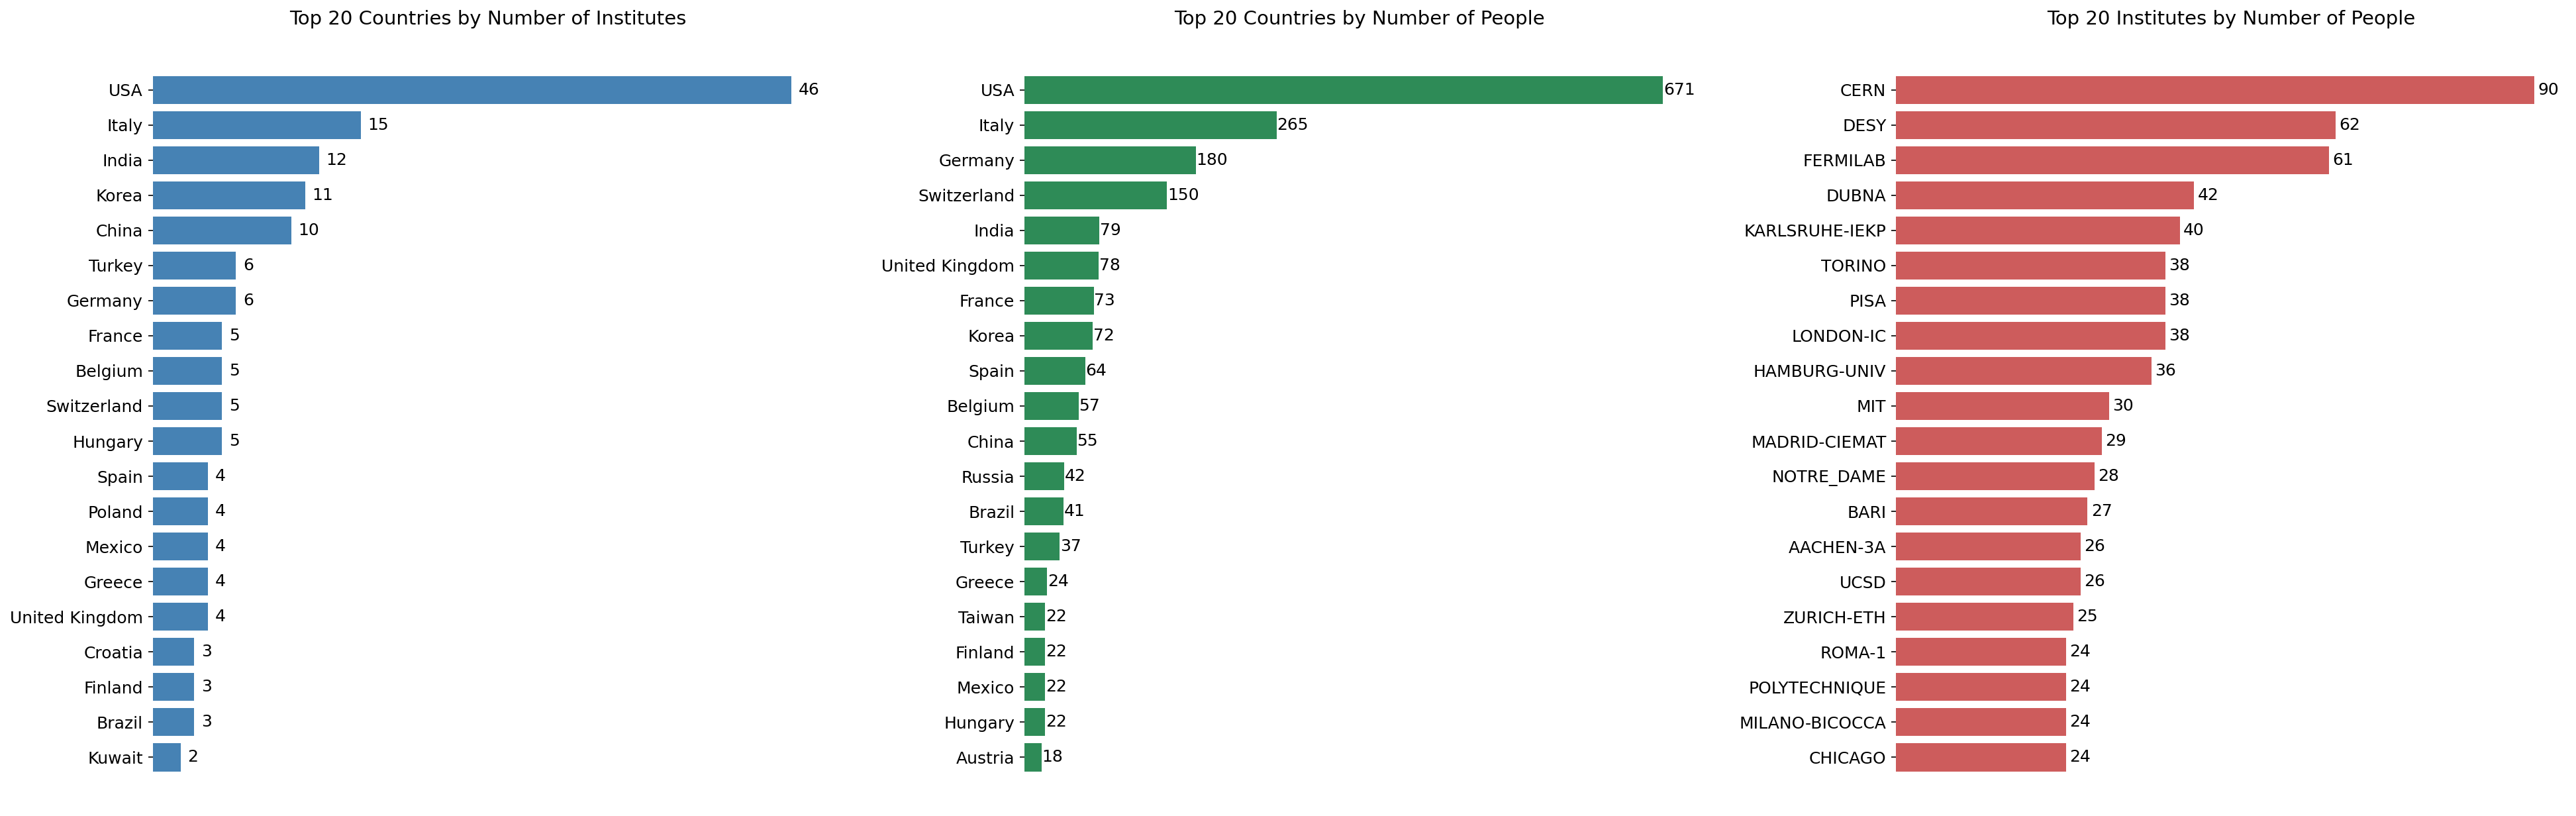

In [5]:
inst_per_country = (
    df[['Institute Code', 'Country']]
    .drop_duplicates()
    .groupby('Country')
    .size()
    .sort_values(ascending=False)
    .head(20)
)
people_per_inst = df['Institute Code'].value_counts().head(20)
people_per_country = df['Country'].value_counts().head(20)

fig, axs = plt.subplots(1, 3, figsize=(27, 10), dpi=150)
axs = axs.flatten()

data = [
    (inst_per_country, 'steelblue', "Top 20 Countries by Number of Institutes"),
    (people_per_country, 'seagreen', "Top 20 Countries by Number of People"),
    (people_per_inst, 'indianred', "Top 20 Institutes by Number of People")
]

for ax, (counts, color, title) in zip(axs, data):
    ax.barh(range(len(counts)), counts.values, color=color)
    ax.set_yticks(range(len(counts)))
    ax.set_yticklabels(counts.index, fontsize=12)
    ax.invert_yaxis()
    for spine in ax.spines.values(): spine.set_visible(False)
    ax.xaxis.set_visible(False)
    for i, val in enumerate(counts.values): ax.text(val + 0.5, i, str(val), va='center', ha='left', fontsize=12)
    ax.set_title(title, fontsize=14, pad=12)

plt.subplots_adjust(left=0.05, right=0.95, wspace=0.3)
plt.savefig('plots/barplot.png')
plt.show()

### Pie charts

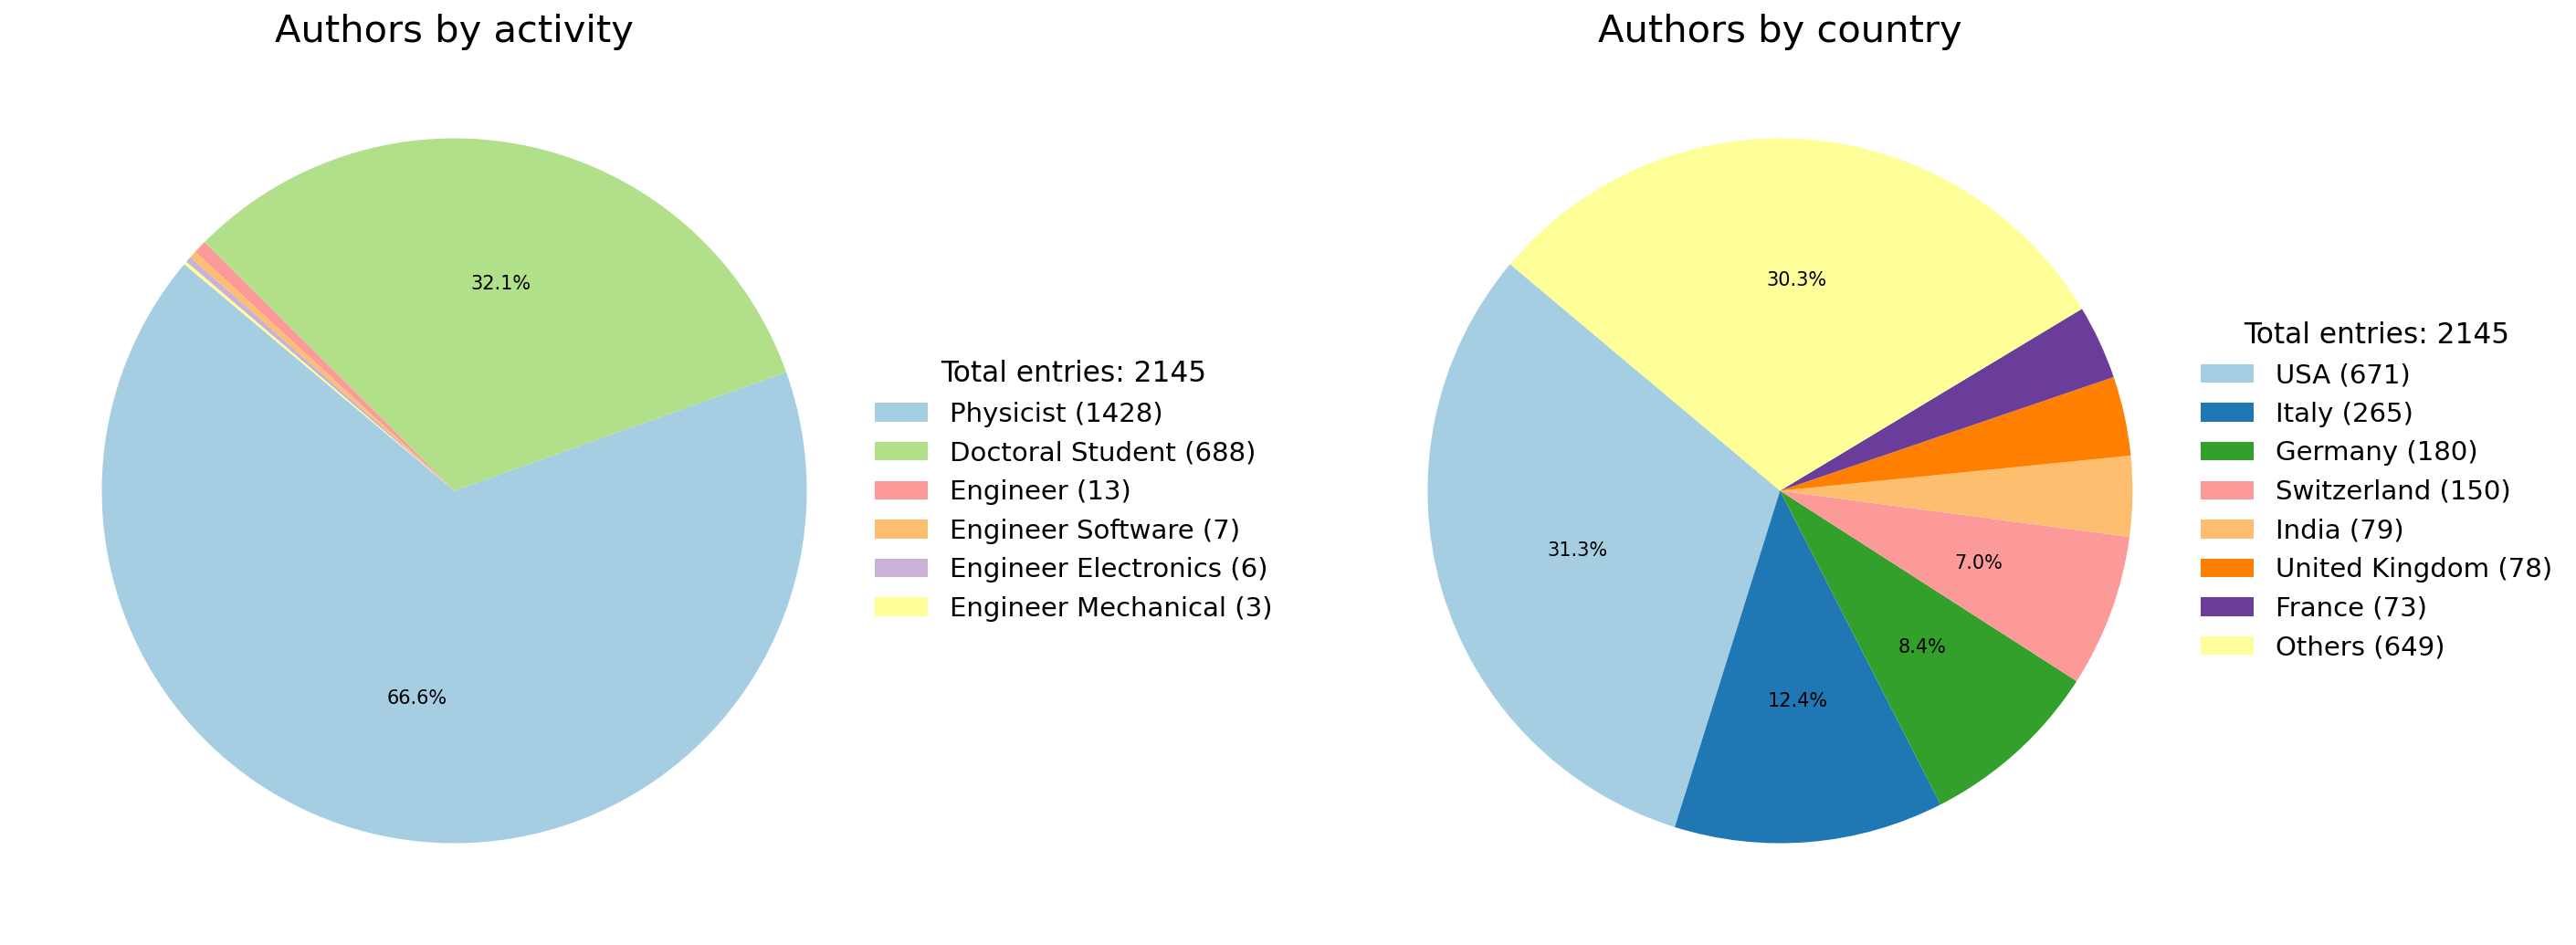

In [6]:
def make_pie(ax, series, title, max_slices=10, cmap_name='Paired'):
    counts = series.value_counts()
    total = counts.sum()

    if max_slices is not None and len(counts) > max_slices:
        counts_top = counts.iloc[:max_slices]
        others = counts.iloc[max_slices:].sum()
        counts = pd.concat([counts_top, pd.Series({'Others': others})])

    cmap = matplotlib.colormaps[cmap_name]
    colors = [cmap(i / len(counts)) for i in range(len(counts))]

    def autopct_func(pct):
        return f'{pct:.1f}%' if pct >= 5 else ''

    wedges, _, _ = ax.pie(
        counts.values,
        autopct=autopct_func,
        startangle=140,
        colors=colors,
        wedgeprops={'edgecolor': 'gray', 'linewidth': 0},
        textprops={'fontsize': 10}
    )
    ax.set_title(title, fontsize=20, pad=1)

    labels_with_counts = [f"{cat} ({cnt})" for cat, cnt in zip(counts.index, counts.values)]
    ax.legend(
        wedges, labels_with_counts,
        loc='center left', bbox_to_anchor=(0.95, 0.5),
        fontsize=14, title=f'Total entries: {total}', title_fontsize=15,
        frameon=False
    )

fig, axes = plt.subplots(1, 2, figsize=(20, 7), dpi=150)
make_pie(axes[0], df['Activity'], 'Authors by activity')
make_pie(axes[1], df['Country'], 'Authors by country', max_slices=7)
plt.tight_layout()
plt.savefig('plots/piechart_authors.png')
plt.show()

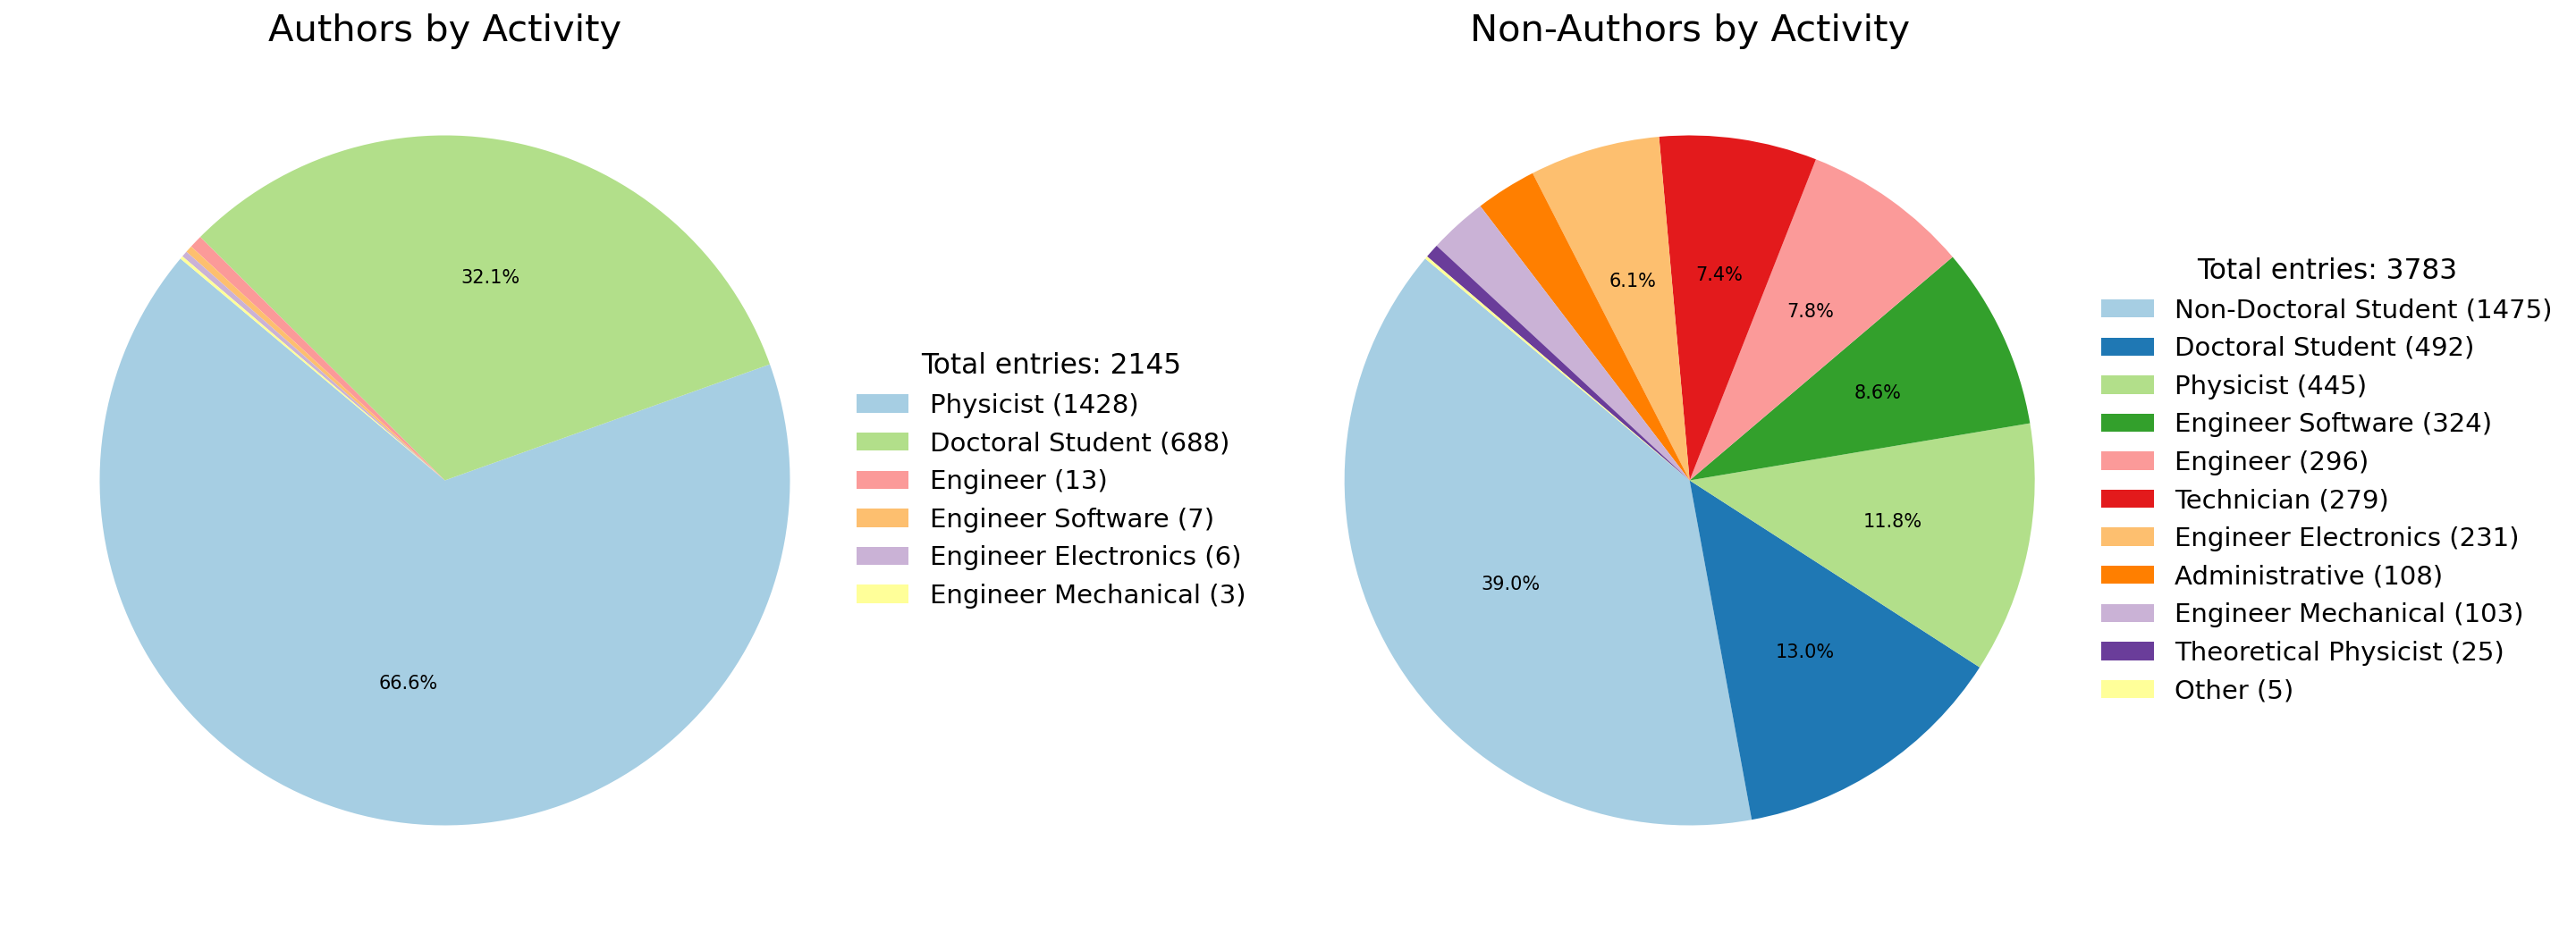

In [7]:
authors_activity = df_all.loc[(df_all['Authorship'] == True) & (df_all['Status'] == 'CMS'), 'Activity']
non_authors_activity = df_all.loc[(df_all['Authorship'] == False) & (df_all['Status'] == 'CMS'), 'Activity']

fig, axes = plt.subplots(1, 2, figsize=(20, 7), dpi=150)
make_pie(axes[0], authors_activity, 'Authors by Activity', max_slices=None)
make_pie(axes[1], non_authors_activity, 'Non-Authors by Activity', max_slices=None)
plt.tight_layout()
plt.savefig('plots/piechart_authors-vs-nonauthors.png')
plt.show()

## Geography

In [8]:
import geopandas as gpd
world = gpd.read_file('offline-country-level-mapdata/ne_110m_admin_0_countries.shp')
name_replacements = {"United States of America": "USA", "United Kingdom": "UK"}
world['NAME'] = world['NAME'].replace(name_replacements)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']), crs="EPSG:4326")

### Group people by country and town:
people_loc = (df.groupby(['Country', 'Town', 'latitude', 'longitude']).size().reset_index(name='count'))
people_gdf = gpd.GeoDataFrame(people_loc, geometry=gpd.points_from_xy(people_loc['longitude'], people_loc['latitude']), crs="EPSG:4326")

# Aggregate unique institutes and group by country:
inst_per_country = (
    df[['Institute Code', 'Country', 'latitude', 'longitude']]
    .drop_duplicates(subset=['Institute Code'])
    .groupby('Country')
    .agg({'Institute Code': 'count', 'latitude': 'mean', 'longitude': 'mean'})
    .rename(columns={'Institute Code': 'inst_count'})
    .reset_index()
)
inst_gdf = gpd.GeoDataFrame(inst_per_country, geometry=gpd.points_from_xy(inst_per_country['longitude'], inst_per_country['latitude']), crs="EPSG:4326")

print('Map and geo-dataframe ready.')

Map and geo-dataframe ready.


### Bubble map

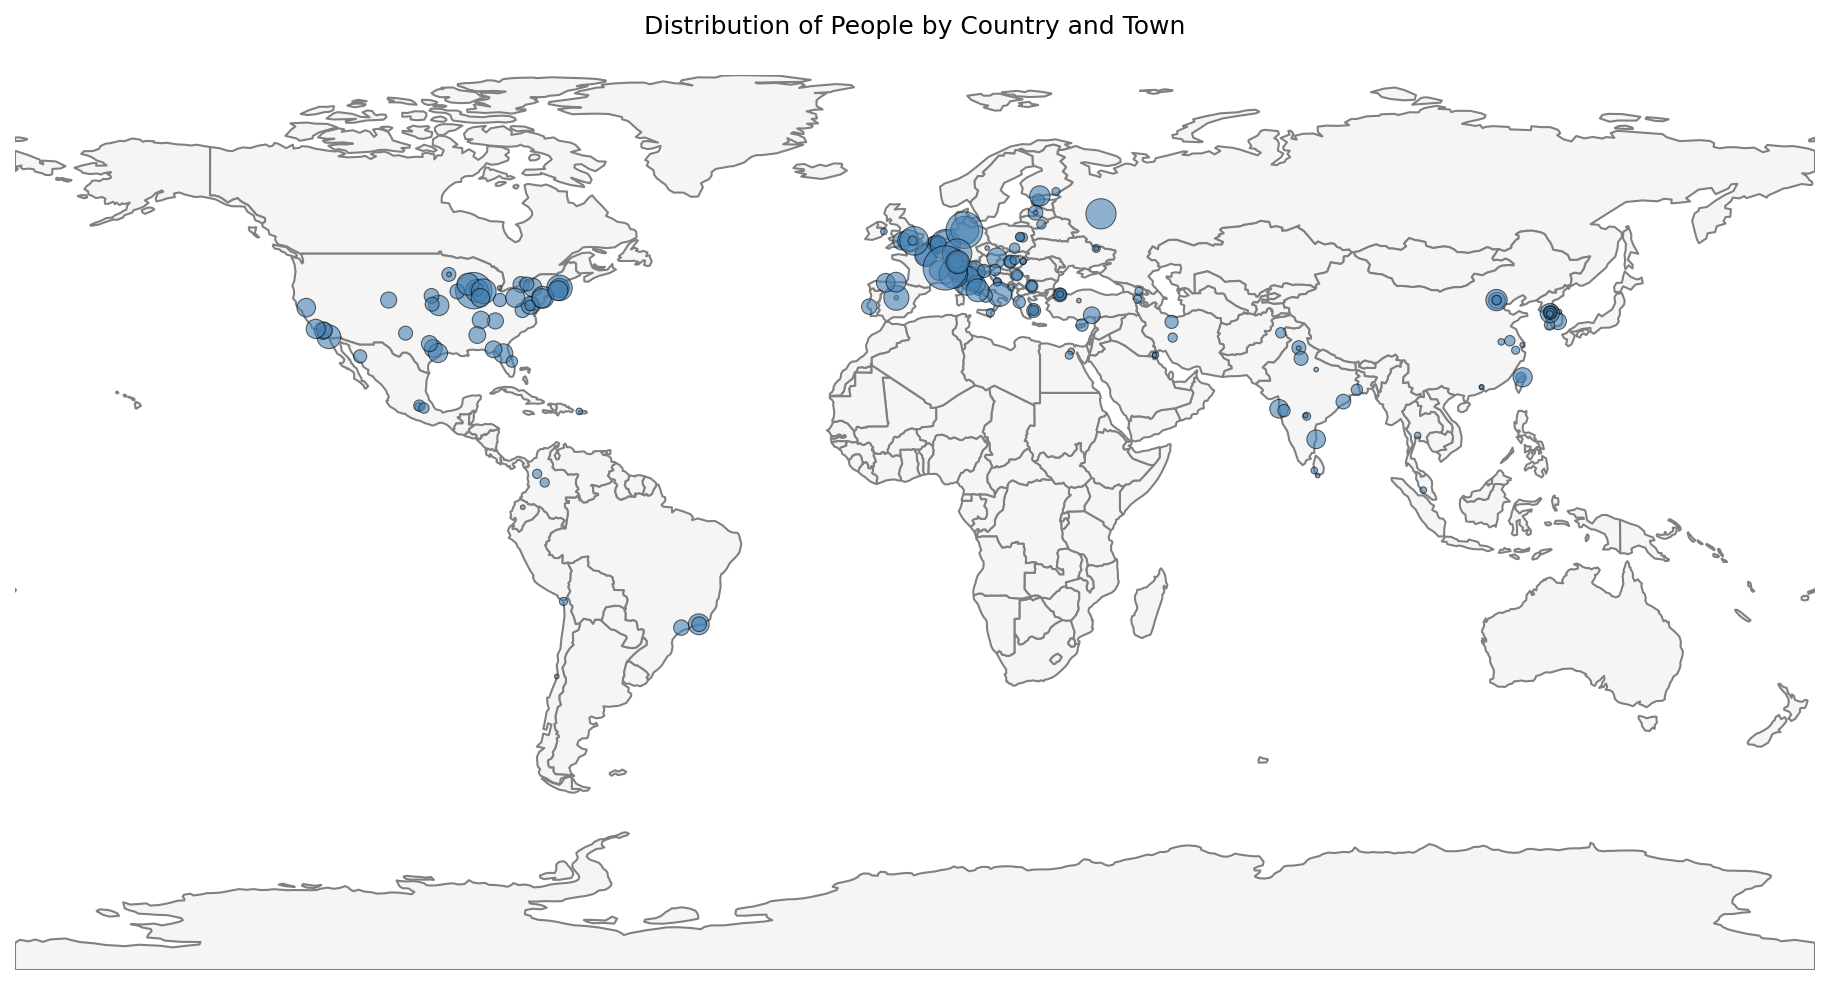

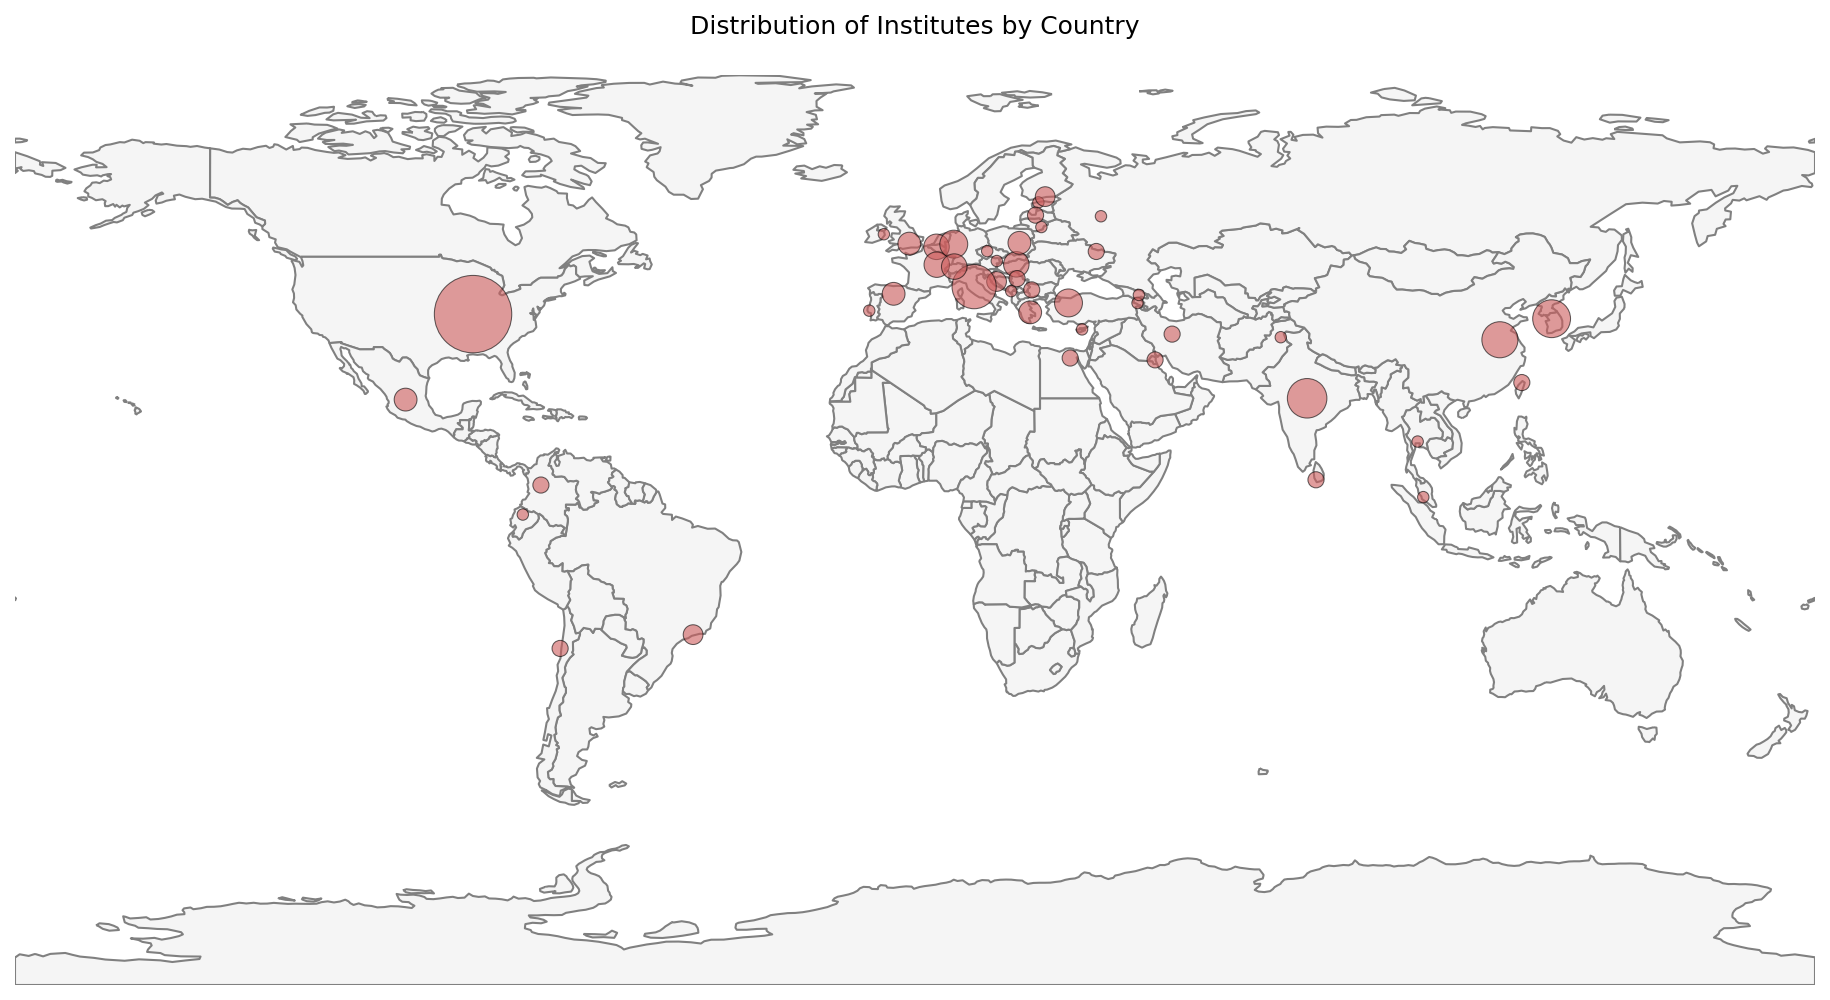

In [9]:
fig1, ax1 = plt.subplots(figsize=(12, 8), dpi=150)
world.plot(ax=ax1, color='whitesmoke', edgecolor='gray')
people_gdf.plot(
    ax=ax1,
    markersize=people_gdf['count']*5,
    alpha=0.6,
    color='steelblue',
    edgecolor='k',
    linewidth=0.5
)
ax1.set_title('Distribution of People by Country and Town', fontsize=12, pad=20)
ax1.axis('off')
fig1.tight_layout(pad=0)

fig2, ax2 = plt.subplots(figsize=(12, 8), dpi=150)
world.plot(ax=ax2, color='whitesmoke', edgecolor='gray')
inst_gdf.plot(
    ax=ax2,
    markersize=inst_gdf['inst_count']*30,
    alpha=0.6,
    color='indianred',
    edgecolor='k',
    linewidth=0.5
)
ax2.set_title('Distribution of Institutes by Country', fontsize=12, pad=20)
ax2.axis('off')
fig2.tight_layout(pad=0)

common_xlim = world.total_bounds[[0, 2]]
common_ylim = world.total_bounds[[1, 3]]
ax1.set_xlim(common_xlim)
ax1.set_ylim(common_ylim)
ax2.set_xlim(common_xlim)
ax2.set_ylim(common_ylim)

fig1.savefig('plots/bubblemap_people.png', bbox_inches='tight', pad_inches=0.25)
fig2.savefig('plots/bubblemap_institutes.png', bbox_inches='tight', pad_inches=0.25)

plt.show()

### Heat maps

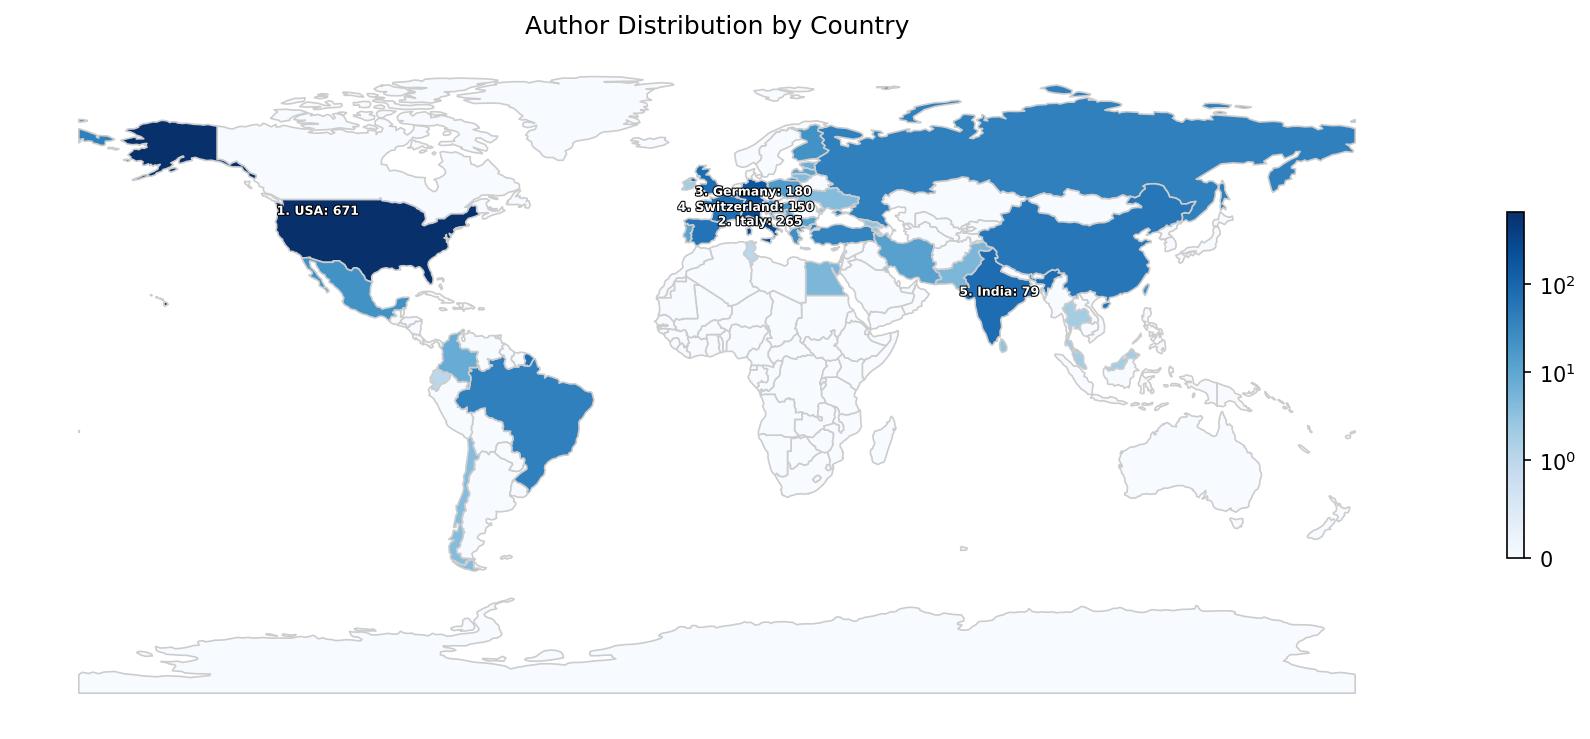

In [10]:
people_per_country = df.groupby('Country').size().reset_index(name='people_count')
people_per_country['Country'] = people_per_country['Country'].replace(name_replacements)
world_people = world.merge(people_per_country, left_on='NAME', right_on='Country', how='left')
world_people['people_count'] = world_people['people_count'].fillna(0)

fig1, ax1 = plt.subplots(figsize=(12, 8), dpi=150)

#norm=plt.Normalize(vmin=0, vmax=20)
#norm=LogNorm(vmin=1, vmax=people_per_country['inst_count'].max())
norm = SymLogNorm(linthresh=1, linscale=1, base=10, vmin=0, vmax=people_per_country['people_count'].max())


world_people.plot(
    column='people_count',
    cmap='Blues',
    linewidth=0.8,
    ax=ax1,
    edgecolor='0.8',
    legend=True,
    legend_kwds={
        'shrink': 0.3,
        'orientation': 'vertical'
    },
    norm=norm
)

top5_people = world_people.nlargest(5, 'people_count')
for i, (_, row) in enumerate(top5_people.iterrows(), 1):
    ax1.annotate(
        f"{i}. {row['NAME']}: {int(row['people_count'])}",
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center', va='center',
        color='white', fontsize=6, weight='bold', alpha=1,
        path_effects=[path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()]
    )

ax1.set_title('Author Distribution by Country')
ax1.axis('off')
plt.tight_layout()
fig1.savefig('plots/heatmap_people.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

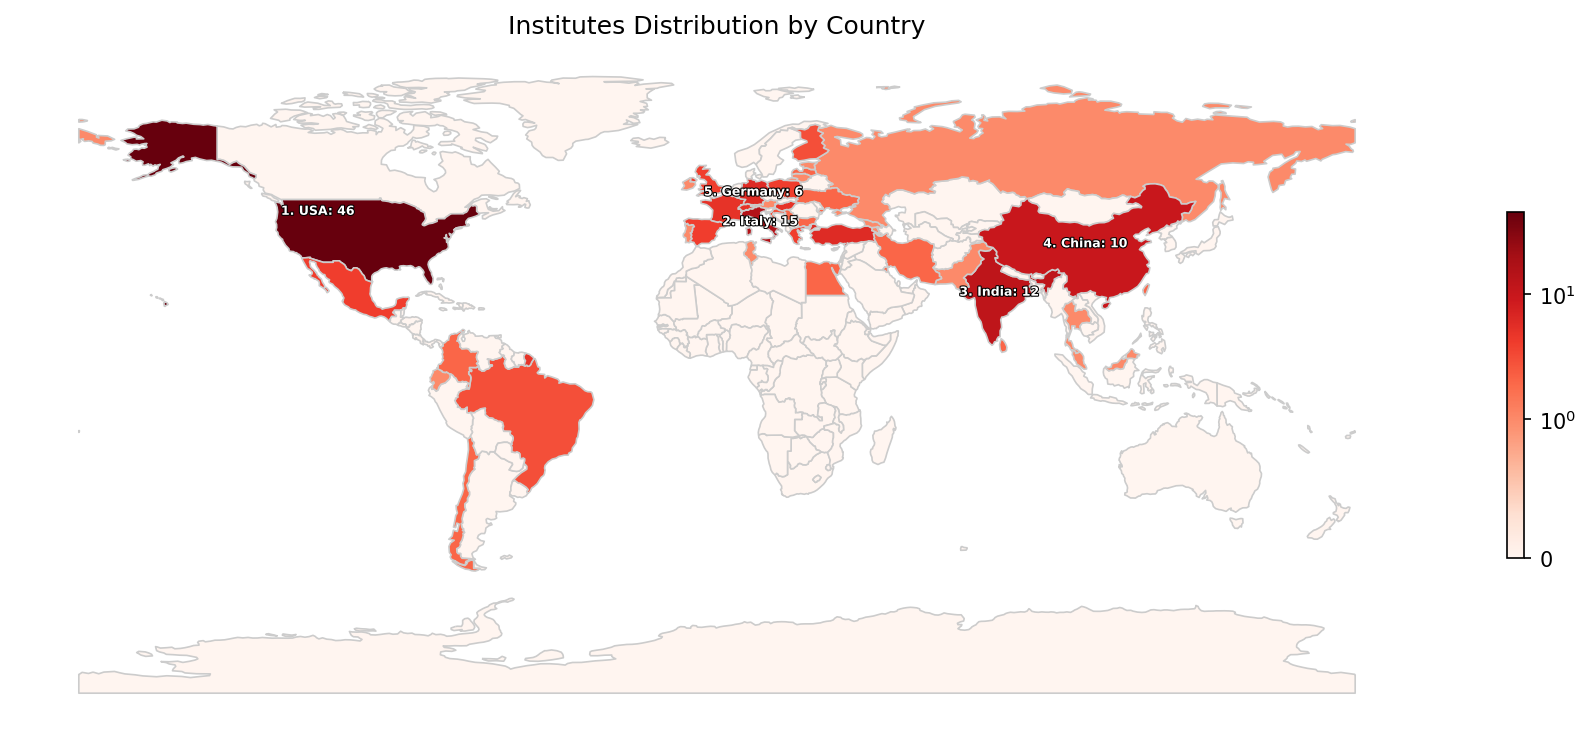

In [11]:
inst_counts = inst_per_country[['Country', 'inst_count']].copy()
inst_counts['Country'] = inst_counts['Country'].replace(name_replacements)
world_inst = world.merge(inst_counts, left_on='NAME', right_on='Country', how='left')
world_inst['inst_count'] = world_inst['inst_count'].fillna(0)

fig2, ax2 = plt.subplots(figsize=(12, 8), dpi=150)

#norm=plt.Normalize(vmin=0, vmax=20)
#norm=LogNorm(vmin=1, vmax=world_inst['inst_count'].max())
norm = SymLogNorm(linthresh=1, linscale=1, base=10, vmin=0, vmax=world_inst['inst_count'].max())

world_inst.plot(
    column='inst_count',
    cmap='Reds',
    linewidth=0.8,
    ax=ax2,
    edgecolor='0.8',
    legend=True,
    legend_kwds={
        'shrink': 0.3,
        'orientation': 'vertical'
    },
    norm=norm
)

top5_inst = world_inst.nlargest(5, 'inst_count')
for i, (_, row) in enumerate(top5_inst.iterrows(), 1):
    ax2.annotate(
        f"{i}. {row['NAME']}: {int(row['inst_count'])}",
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center', va='center',
        color='white', fontsize=6, weight='bold', alpha=1,
        path_effects=[path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()]
    )
    
ax2.set_title('Institutes Distribution by Country')
ax2.axis('off')
plt.tight_layout()
fig2.savefig('plots/heatmap_institutes.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Generate Interactive Map

**Note:** This imports a map from OpenStreetMap and places individual institutes on the map based on latitude and longitude. The map is recognized by the UN, and individual countries may choose to agree to it.

In [12]:
import folium

institutes = df_inst[['Code', 'Name', 'Country', 'Town']].copy()
institutes['latitude'] = institutes['Code'].map(lambda c: geo_data[c]['latitude'] if c in geo_data else None)
institutes['longitude'] = institutes['Code'].map(lambda c: geo_data[c]['longitude'] if c in geo_data else None)

institutes = institutes.rename(columns={'Name': 'Institute Name'})

missing = institutes[institutes[['latitude', 'longitude']].isna().any(axis=1)]
if not missing.empty:
    print("Institutes missing coordinates:")
    print(missing[['Code', 'Institute Name']])

institutes = institutes.dropna(subset=['latitude', 'longitude'])

# Create the folium map
m = folium.Map(
    location=[institutes['latitude'].mean(), institutes['longitude'].mean()],
    zoom_start=3,
    tiles=None
)

# Add base layers
folium.TileLayer(
    tiles='https://{s}.basemaps.cartocdn.com/rastertiles/voyager/{z}/{x}/{y}{r}.png',
    attr='&copy; OpenStreetMap contributors & CartoDB',
    name='CartoDB Voyager'
).add_to(m)

folium.TileLayer(
    tiles='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
    attr='&copy; OpenStreetMap contributors',
    name='OpenStreetMap'
).add_to(m)

# Add institute markers
for _, row in institutes.iterrows():
    html_popup = f"""
    <div style="font-size: 14px;">
        <b>{row['Institute Name']}</b><br>
        {row['Town']}, {row['Country']}<br>
        <i>Latitude:</i> {row['latitude']}<br>
        <i>Longitude:</i> {row['longitude']}
    </div>
    """
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(html_popup, max_width=300),
        tooltip=row['Institute Name'],
        icon=folium.Icon(color='red', icon='university', prefix='fa')
    ).add_to(m)

folium.LayerControl().add_to(m)
m.save("interactive-map.html")
print('Map generated. Open the html file in a web-browser.')

Map generated. Open the html file in a web-browser.
